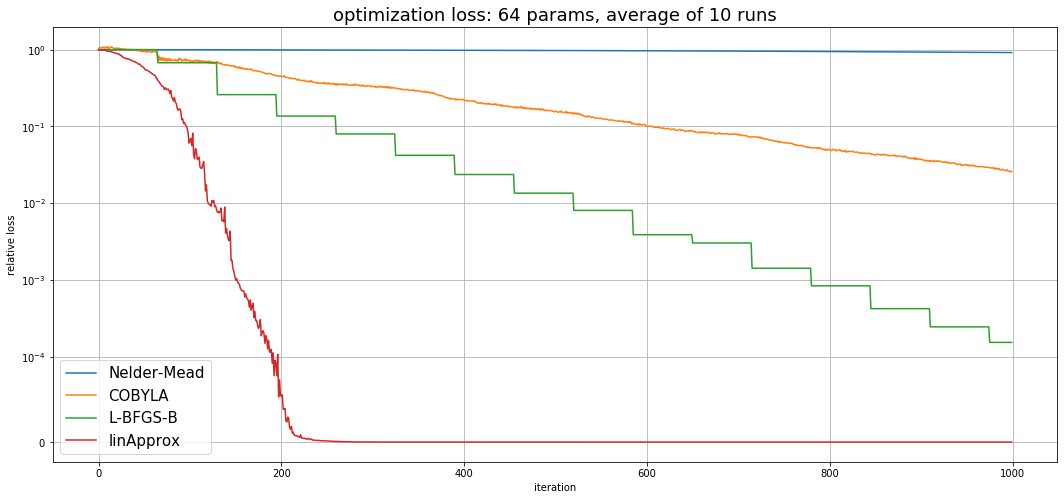

,Method,Avg Loss,iters/sec
0,Nelder-Mead,0.915,14.2k
1,COBYLA,0.0253,4.4k
2,L-BFGS-B,0.00015,45.8k
3,linApprox,1.62e-12,2.3k


In [117]:
import numpy as np

dimX = 64; dimY = 256
maxNumIters = 1000

# define problem
A=[]; a0=[]; xTarget=[]; xStart=[]; yTarget=[]
def setupRandomProblem():
    global A, a0, xTarget, xStart, yTarget
    A  = np.random.randn(dimY,dimX)
    a0 = np.random.randn(dimY)
    xTarget = np.random.rand(dimX)-.5
    xStart  = np.random.rand(dimX)-.5
    yTarget = blackboxFunction(xTarget)

# this is the unknown function that we want to invert
def blackboxFunction(x):
    return np.dot(A,np.sin(x) + np.exp(x))+ a0 # slightly nonlinear function

def lossFun(y):
    L = np.sum((y-yTarget)**2)
    global lossList, lossCount # needed to count iterations used by scipy.optimize
    if lossCount<maxNumIters:
        lossList[lossCount] = L**.5
    lossCount += 1
    return L;

def linApprox_search(xStart, yTarget, nIter):
    nX = len(xStart); nMem = nX+1
    memX = np.zeros((nMem, nX))
    memY = np.zeros((nMem, len(yTarget)))
    memLoss = np.zeros(nMem)
    x = 1.0*xStart # make hard copy
    
    def regularizedLS(A, b, regMult, regAdd):
        I = np.eye(A.shape[1])
        return np.linalg.solve(np.dot(A.T,A)*(1+regMult*I)+regAdd*I, np.dot(A.T,b))
    
    for iter in range(nIter):
        m = iter % nMem
        if iter<3:
            x += .03 * (np.random.rand(nX)-.5)
        else:
            M = np.minimum(iter,nMem) # current memory size
            minI = np.argmin(memLoss[:M]) # get current best
            dI = (np.arange(nMem) != minI) * (np.arange(nMem)<iter)
            dX = memX[dI,:] - memX[minI,:]
            dY = memY[dI,:] - memY[minI,:]
            yStep = yTarget - memY[minI,:]
        
            # estimate A such that A*dx ~= dy (with small tikhonov term)
            lsA = regularizedLS(dX, dY, .001, 1e-20).T
        
            # find x minimizing norm(A*x - yStep)
            xStep = regularizedLS(lsA, yStep, .01, 1e-20)
            stepNorm = np.sum(xStep**2)
            x = memX[minI,:] + xStep * np.minimum(1.0, 1.0 / stepNorm)
        
        memX[m,:] = x
        memY[m,:] = blackboxFunction(x)
        memLoss[m] = lossFun(memY[m,:])

    return x

##### gradient-free scipy.optimize methods for comparison ############
import time
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
%matplotlib inline

methods = ['Nelder-Mead', 'COBYLA', 'L-BFGS-B', 'linApprox']
methStats = np.zeros([len(methods),3])

numReps = 10
avgLossMat = np.zeros((maxNumIters,len(methods)))

for rep in range(numReps):
    setupRandomProblem()
    for mInd, methodName in enumerate(methods):
        lossList = np.zeros(maxNumIters)
        lossCount = 0
        T0 = time.perf_counter()
        if methodName=='linApprox':
            res = linApprox_search(xStart, yTarget, maxNumIters)
        else:
            # standalone loss function needed for scipy.optimize methods
            def blackboxLoss(x):
                y = blackboxFunction(x)
                return lossFun(y)
            opts = {'maxiter':maxNumIters, 'disp':False}
            res = scipy.optimize.minimize(blackboxLoss, xStart, method=methodName, options=opts)
        
        assert(lossCount>=maxNumIters)
        avgLossMat[:,mInd] += lossList
        methStats[mInd,0] += lossCount
        methStats[mInd,1] += (time.perf_counter()-T0)
        methStats[mInd,2] += np.min(lossList)/lossList[0]

plt.figure(figsize=(18, 8));
_=plt.plot(avgLossMat/avgLossMat[0,0])
plt.rcParams.update({'font.size': 15})
plt.yscale('symlog', linthreshy=1e-4)
plt.title("optimization loss: %d params, average of %d runs" % (dimX, numReps))
plt.xlabel('iteration')
plt.ylabel('relative loss')
plt.grid(True)
plt.legend(methods)
plt.show()

tabData = []
for ind, meth in enumerate(methods):
    tabData.append([meth, "%.3g" % (methStats[ind,2]/numReps), "%.1fk" % (1e-3*methStats[ind,0]/methStats[ind,1]) ])

import pandas as pd
pd.DataFrame(tabData, columns=["Method", "Avg Loss", "iters/sec"])
